#Grad-CAM

This Jupyter notebook demonstrates the use of Captum library for explaining image classification models. We will use a pre-trained ResNet-18 model from torchvision and apply LayerGradCam, a technique for visualizing the importance of different regions of an image in the model's prediction. We will load an image and generate the attribution map and Grad-CAM heatmap, which highlight the regions in the image that contribute most to the predicted label. We will also visualize the Grad-CAM heatmap superimposed on the original image to better understand which regions the model is attending to. This notebook can serve as a starting point for understanding how to use Captum to explain the predictions of image classification models.

This Jupyter notebook is based on:

*   https://captum.ai/tutorials/Segmentation_Interpret
*   https://captum.ai/docs/attribution_algorithms###GradCAM
*   https://arxiv.org/abs/1610.02391

#### Installing Captum Library

The following line installs version 0.6.0 of the Captum library.

This version is used because it is compatible with the other libraries used in this notebook.

In [1]:
!pip install matplotlib==3.6 captum==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.5 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


#### Configuring Matplotlib for Displaying Images

The following line configures Matplotlib to display images without padding.

This configuration is necessary because Matplotlib adds padding around images by default, which can affect the layout of the notebook. Setting the `bbox_inches` parameter to `None` removes the padding and ensures that images are displayed at their original size without any cropping or scaling.

In [2]:
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}

#### Using GradCAM

This cell imports necessary libraries for deep learning and image processing with PyTorch, torchvision, PIL, and Captum. It reads an image and preprocesses it by resizing, tensor conversion, and normalization using predefined mean and standard deviation. A pre-trained ResNet-18 model is loaded and set to evaluation mode. The processed image tensor is passed through the model to obtain the output, and the softmax function is applied to get probabilities. 

The label index with the maximum probability value is identified, and its corresponding percentage probability is printed. LayerGradCam is used with the model's fourth layer to generate an attribution map, highlighting the significant regions in the image that led to the prediction.

The code can be used to understand how the ResNet model makes predictions and which regions of the input image are important for a specific prediction. It can also be used to debug the model's behavior and check if it is focusing on the correct regions of the input image.

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from captum.attr import visualization as viz
from captum.attr import LayerGradCam, LayerAttribution
import matplotlib.gridspec as gridspec
import torch.nn.functional as F

img = Image.open('/content/drive/MyDrive/Colab Notebooks/images/car_blue.jpg')

# Define the input size of the model
input_size = 224

# Preprocessing the image
preprocess = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img_tensor = preprocess(img)
img_tensor = img_tensor.unsqueeze(0)

# Loading a pre-trained Resnet model
model = models.resnet18(pretrained=True)
model.eval()

output = model(img_tensor)
pred = output.detach().numpy()[0]
pred_label = int(np.argmax(pred))

# Make predictions with the model
output_probs = F.softmax(output, dim=1).squeeze(0)
# Find the index of the maximum value
label_idx = output_probs.argmax()
# Get the corresponding probability
probability = output_probs[label_idx].item() * 100 # converting to percentage
print(f"Label Index: {label_idx}, Probability: {probability:.2f}%")

grad_cam = LayerGradCam(model, model.layer4)
attr_map = grad_cam.attribute(img_tensor, target=pred_label)

Label Index: 656, Probability: 35.05%


#### Visualization

This cell focuses is processing and visualizing an attribution map generated by Grad-CAM. The attribution map is first squeezed to remove unnecessary dimensions and then normalized to bring its values within the 0 to 1 range. It's then resized to match the original image size using bicubic interpolation and again normalized. 

The original image is converted to a NumPy array and both the original image and the resized attribution map are plotted side by side using Matplotlib. The Grad-CAM visualization is superimposed on the original image with a color map ('jet') and an accompanying color bar, effectively highlighting the regions in the image that contributed the most to the model's prediction.

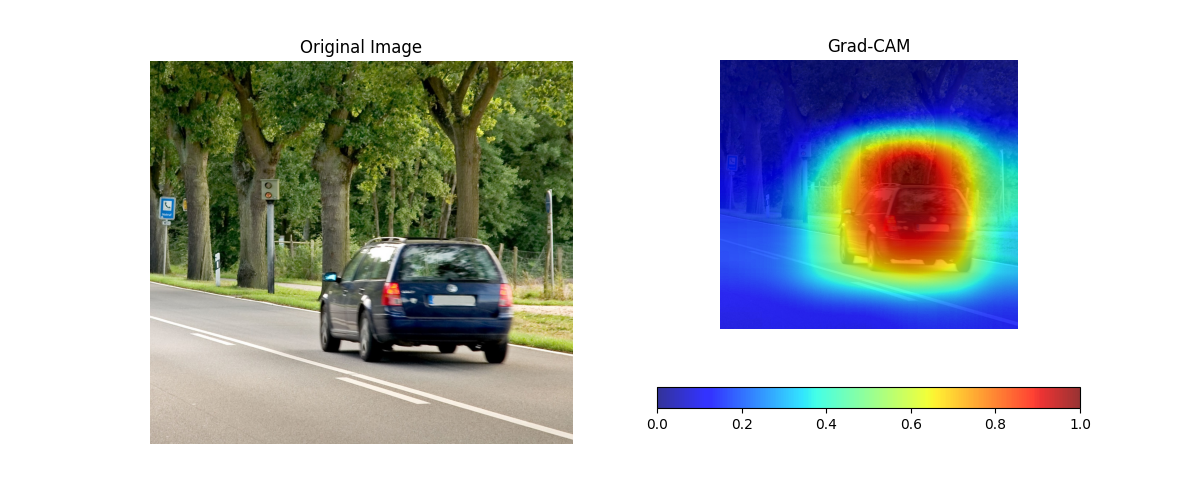

In [ ]:
# Reshape the attribution map
attr_map_np = attr_map.squeeze().cpu().detach().numpy()

# Normalize the values
attr_map_np = (attr_map_np - np.min(attr_map_np)) / (np.max(attr_map_np) - np.min(attr_map_np))

# Reshape the attribution map
attr_map_np = attr_map.squeeze().cpu().detach().numpy()

# Normalize the attribution map values
attr_map_np = (attr_map_np - np.min(attr_map_np)) / (np.max(attr_map_np) - np.min(attr_map_np))

# Resize the attribution map to the original image size
attr_map_resized = np.array(Image.fromarray((attr_map_np * 255).astype(np.uint8)).convert("L").resize(img.size, Image.BICUBIC))

# Normalize the resized attribution map values
attr_map_resized = attr_map_resized / 255.0

# Convert the original image to numpy array
original_img_np = np.array(img)

# Plot the original image
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_img_np)
plt.title('Original Image')
plt.axis('off')

# Plot the Grad-CAM attribution map
plt.subplot(1, 2, 2)
plt.imshow(original_img_np)
cax = plt.imshow(attr_map_resized, cmap='jet', alpha=0.8)
plt.title('Grad-CAM')
plt.axis('off')

# Add colorbar
cbar = plt.colorbar(cax, orientation='horizontal')

plt.show()
